In [7]:
import warnings
warnings.filterwarnings('ignore') # :clown:

In [8]:
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
files = glob('../data/ecg_preprocessed/*.csv')

In [4]:
df = pd.read_csv(files[0])
df.head()

,timestamp,signal,signal_normalised,subject_id,category,code,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,...,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,2017-12-15 10:16:06+00:00,-0.000073,0.493088,30100,NaN,NaN,-0.000073,-0.000095,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,2017-12-15 10:16:06.001000+00:00,-0.000083,0.492200,30100,NaN,NaN,-0.000083,-0.000097,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,2017-12-15 10:16:06.002000+00:00,-0.000095,0.491090,30100,NaN,NaN,-0.000095,-0.000100,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,2017-12-15 10:16:06.003000+00:00,-0.000103,0.490368,30100,NaN,NaN,-0.000103,-0.000102,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,2017-12-15 10:16:06.004000+00:00,-0.000110,0.489757,30100,NaN,NaN,-0.000110,-0.000105,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0


**Signal per Quarter**

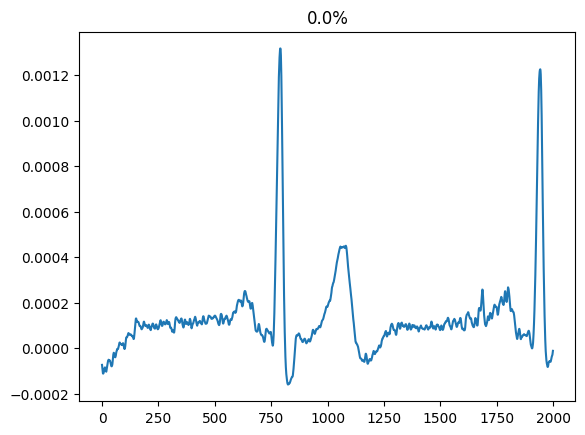

In [79]:
idx = int(len(df) * 0)
window = 2000

plt.plot(range(window),df['signal'][idx:idx+window])
plt.title(f'{(idx / len(df)) * 100}%')
plt.show()

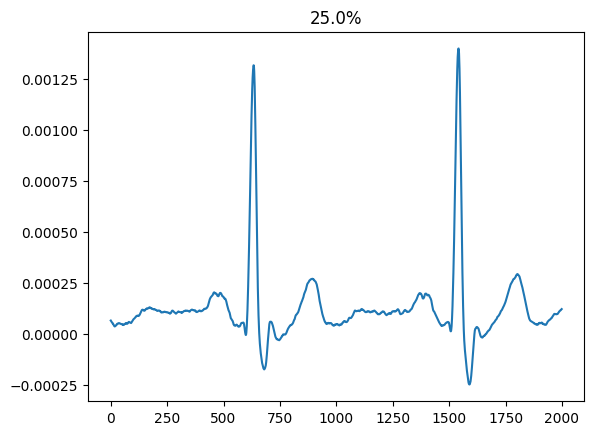

In [80]:
idx = int(len(df) * .25)
plt.plot(range(window),df['signal'][idx:idx+window])
plt.title(f'{(idx / len(df)) * 100}%')
plt.show()

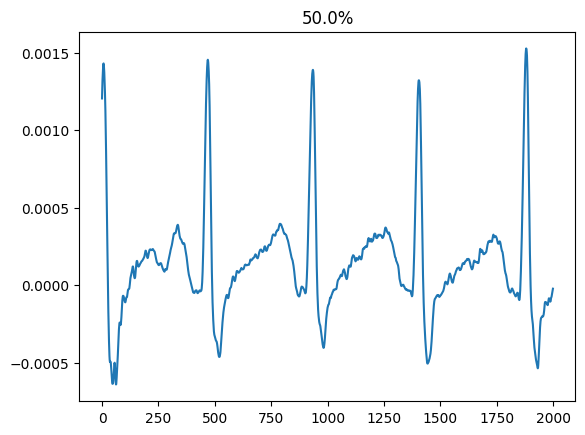

In [81]:
idx = int(len(df) * .5)
plt.plot(range(window),df['signal'][idx:idx+window])
plt.title(f'{(idx / len(df)) * 100}%')
plt.show()

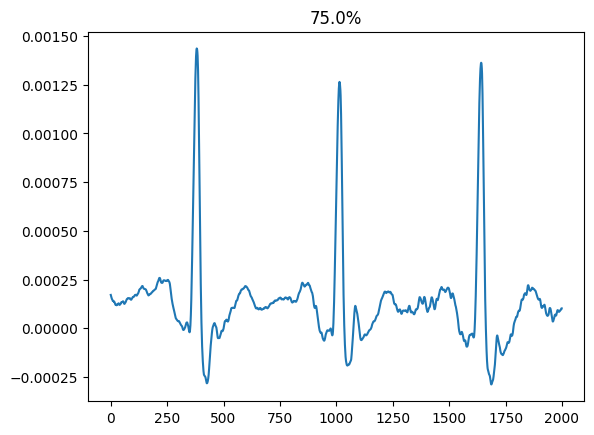

In [82]:
idx = int(len(df) * 0.75)
plt.plot(range(window),df['signal'][idx:idx+window])
plt.title(f'{(idx / len(df)) * 100}%')
plt.show()

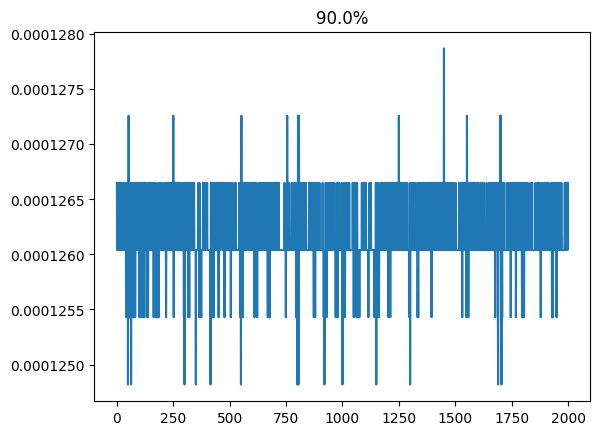

In [106]:
idx = int(len(df) * 0.90)
plt.plot(range(window),df['signal'][idx:idx+window])
plt.title(f'{(idx / len(df)) * 100}%')
plt.show()

### Filters

In [96]:
from scipy import signal

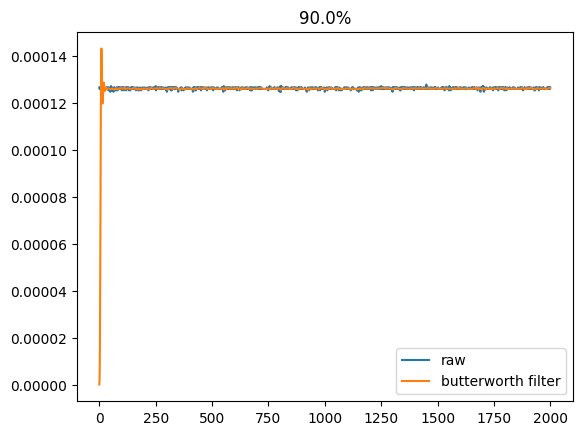

In [107]:
hz = 1000
nyquist = 0.5 * hz
cutoff = 100
b, a = signal.butter(5, cutoff / nyquist, btype='low')

plt.plot(range(window), df['signal'][idx:idx+window], label='raw')
plt.plot(range(window), signal.lfilter(b, a, df['signal'][idx:idx+window]), label='butterworth filter')
plt.title(f'{(idx / len(df)) * 100}%')
plt.legend()
plt.show()

### https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-spr.2020.0104

**Presence of AWGN (Additive White Gaussian noise)** \
Wavelet Transform

In [62]:
import pywt

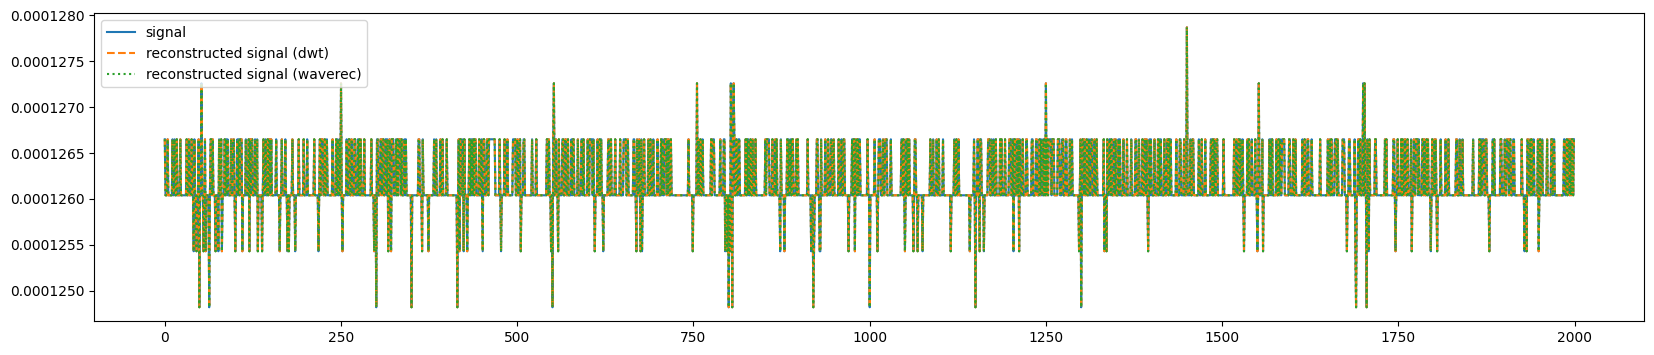

In [91]:
(cA1, cD1) = pywt.dwt(df['signal'][idx:idx+window], 'db2', 'smooth')
dwt_reconstructed_signal = pywt.idwt(cA1, cD1, 'db2', 'smooth')

coeffs = pywt.wavedec(df['signal'][idx:idx+window], 'db2', level=8)
waverec_reconstructed_signal = pywt.waverec(coeffs, 'db2')

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(range(window),df['signal'][idx:idx+window], label='signal')
ax.plot(range(window),dwt_reconstructed_signal, label='reconstructed signal (dwt)', linestyle='--')
ax.plot(range(window),waverec_reconstructed_signal, label='reconstructed signal (waverec)', linestyle='dotted')
ax.legend(loc='upper left')
plt.show()

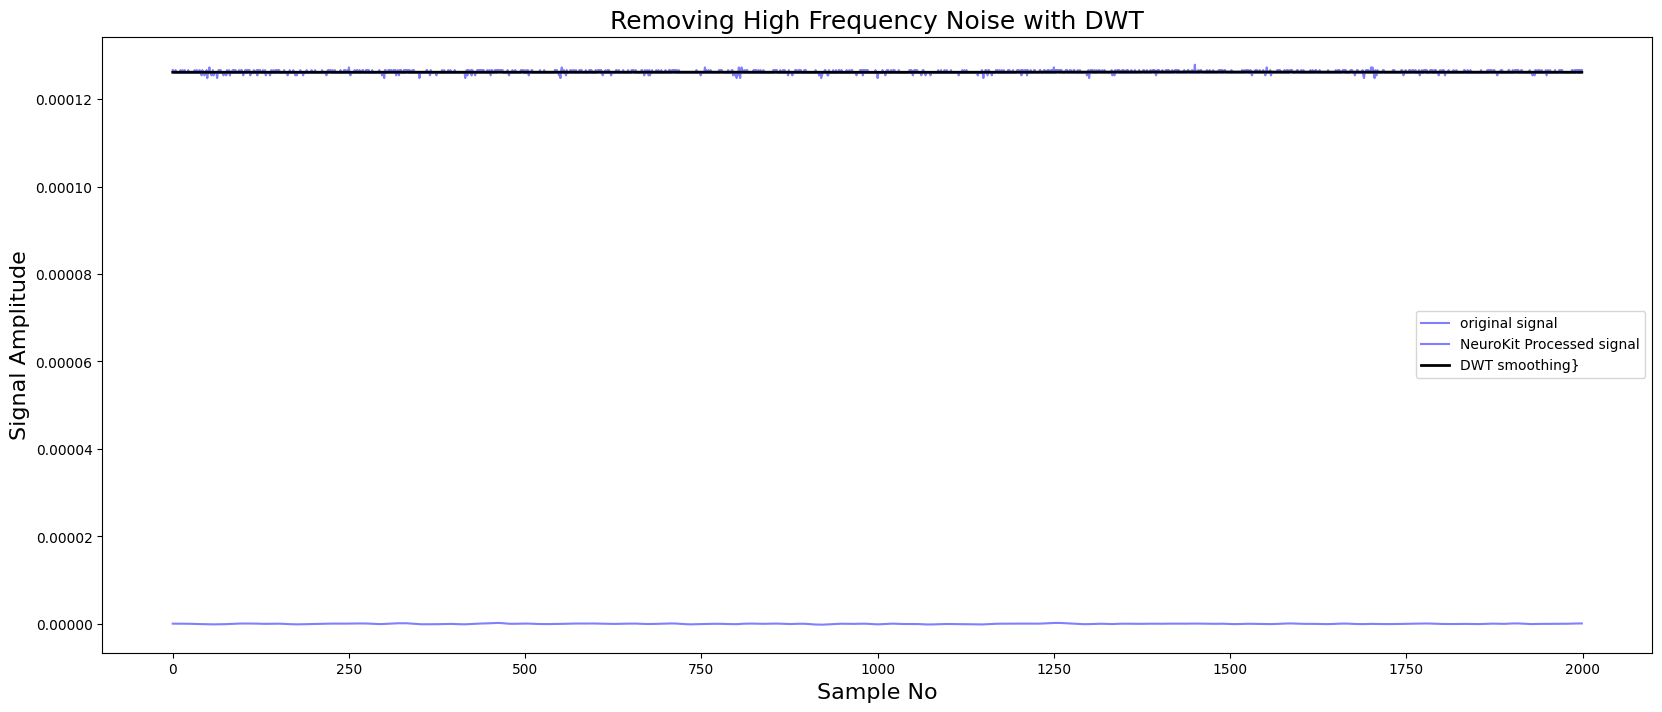

In [95]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(window),df['signal'][idx:idx+window], color="b", alpha=0.5, label='original signal')
ax.plot(range(window),df['ECG_Clean'][idx:idx+window], color="b", alpha=0.5, label='NeuroKit Processed signal')
rec = lowpassfilter(df['signal'][idx:idx+window], 0.4)
ax.plot(range(window),rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()